In [1]:
import os
import glob
import time
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as func
from DatasetGenerator import DatasetGenerator
from ChexnetTrainer import ChexnetTrainer
from DensenetModels import DenseNet121
from DensenetModels import DenseNet169
from DensenetModels import DenseNet201
import cv2
from PIL import Image
import sklearn
from sklearn.metrics.ranking import roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from graphviz import Digraph
import itertools

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [3]:
def searchpath(path):
    if os.path.isdir(path):
        files = []
        for root, dirs, filenames in os.walk(path):
            files += map(lambda f:os.path.join(root, f), filenames)
    else:
        files =[path]
    return files

### Label
#### make label list

讀取chext_xray中，有層級架構的的jpeg影像檔，以list形式存取。

從路徑名來分類，創建labellist，當中分三類(source：圖片路徑、label0 label1：兩向量的label、set：資料類別)

將資料做shuffle

In [12]:
files =searchpath("""path to the file 'chest_xray'""")
labellist={}
labellist['source']=[]
labellist['label0']=[]
labellist['label1']=[]
labellist['set']=[]
for i in files:
    if i.split('/')[-1].split('.')[-1]=='jpeg':
        if i.split('/')[-2]=='NORMAL':
            labellist['source'].append(i)
            labellist['label0'].append(0)
            labellist['label1'].append(1)
            labellist['set'].append(i.split('/')[-3])
        elif i.split('/')[-2]=='PNEUMONIA':
            labellist['source'].append(i)
            labellist['label0'].append(1)
            labellist['label1'].append(0)
            labellist['set'].append(i.split('/')[-3])
df=pd.DataFrame(labellist)
df=df.sample(frac=1) #做shuffle

In [ ]:
df[df.set=='train'].head()

#### make label txt file

創建三種txt檔：train、test、val

label有兩種：01 Normal、10 Pneumonia (在檔名上有virus、bacteria兩種)

In [13]:
train=[]
test=[]
val=[]
for l in labellist['source']:    
    if l.split('/')[-3]=='train':
        filename=l.split('/')[-1]
        if not (('virus'  in filename) or ('bacteria' in filename)):
            filename+=' 0 1'
        else:
            filename+=' 1 0'
        train.append(filename)
        
    if l.split('/')[-3]=='test':
        filename=l.split('/')[-1]
        if not (('virus'  in filename) or ('bacteria' in filename)):
            filename+=' 0 1'
        else:
            filename+=' 1 0'
        test.append(filename)
        
    if l.split('/')[-3]=='val':
        filename=l.split('/')[-1]
        if not (('virus'  in filename) or ('bacteria' in filename)):
            filename+=' 0 1'
        else:
            filename+=' 1 0'
        val.append(filename)

#---- Turn list into txt file
with open('train.txt', 'w') as f:
    for item in train:
        f.write("%s\n" %item)
with open('test.txt', 'w') as f:
    for item in test:
        f.write("%s\n" %item)
with open('val.txt', 'w') as f:
    for item in val:
        f.write("%s\n" %item)

### Train

#### setting

In [14]:
#---- Path to the directory with images
pathDirData='./database'

#---- Paths to the files with training, validation and testing sets.
#---- Each file should contains pairs [path to image, output vector]
#---- Example: images_011/00027736_001.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
pathFileTrain='./train.txt'
pathFileTest='./test.txt'
pathFileVal='./val.txt'


DENSENET121 = 'DENSE-NET-121'
DENSENET169 = 'DENSE-NET-169'
DENSENET201 = 'DENSE-NET-201'

timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

#---- Neural network parameters: type of the network, is it pre-trained 
#---- on imagenet, number of classes
nnArchitecture = DENSENET121
nnIsTrained = True
nnClassCount = 2

#---- Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 100

#---- Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = 256
imgtransCrop = 224

pathModel = 'm-' + timestampLaunch + '.pth.tar'

#### run trainer (！)

ChexnetTrainer.train(pathDirData, pathFileTrain, pathFileVal, nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, imgtransResize, imgtransCrop, timestampLaunch, None)

#### parameter of trainer (for check only)

In [15]:
(pathDirData, pathFileTrain, pathFileVal, nnArchitecture, nnIsTrained, nnClassCount, trBatchSize, trMaxEpoch, imgtransResize, imgtransCrop, timestampLaunch, None)

('./database',
 './train.txt',
 './val.txt',
 'DENSE-NET-121',
 True,
 2,
 16,
 100,
 256,
 224,
 '14012019-153439',
 None)

### Test

#### setting

In [16]:
#---- Path to the directory with images
pathDirData='./database'

#---- Paths to the files with training, validation and testing sets.
#---- Each file should contains pairs [path to image, output vector]
#---- Example: images_011/00027736_001.png 0 0 0 0 0 0 0 0 0 0 0 0 0 0
pathFileTrain='./train.txt'
pathFileTest='./test.txt'
pathFileVal='./val.txt'

pathModel='m-22122018-030326.pth.tar'
timestampLaunch='22122018-030326'

DENSENET121 = 'DENSE-NET-121'
CLASS_NAMES =  ['Normal', 'Pneumonia']

#---- Training settings: batch size, maximum number of epochs
trBatchSize = 4
trMaxEpoch = 100

#---- Neural network parameters: type of the network, is it pre-trained 
#---- on imagenet, number of classes
nnArchitecture = DENSENET121
nnIsTrained = True
nnClassCount = 2

#---- Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = 256
imgtransCrop = 224

#### remove unnecessary part in model

In [17]:
# 在ChexnetTrainer.test的內容

model = DenseNet121(nnClassCount, nnIsTrained).cuda()
model = torch.nn.DataParallel(model).cuda() 
checkpoint = torch.load(pathModel)

#state_dict = a['state_dict']
state_dict = checkpoint['state_dict']
remove_data_parallel = False # Change if you don't want to use nn.DataParallel(model)

pattern = re.compile(
    r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:\d+\.)\.(?:weight|bias|running_mean|running_var))$')
for key in list(state_dict.keys()):
    match = pattern.match(key)
    new_key = match.group(1) + match.group(2) if match else key
    new_key = new_key[7:] if remove_data_parallel else new_key
    state_dict[new_key] = state_dict[key]
    # Delete old key only if modified.
    if match or remove_data_parallel: 
        del state_dict[key]
model.load_state_dict(state_dict)

/usr/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Evaluation for Training

In [18]:
#-------------------- SETTINGS: DATA TRANSFORMS, TEN CROPS
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

#-------------------- SETTINGS: DATASET BUILDERS
transformList = []
transformList.append(transforms.Resize(imgtransResize))
transformList.append(transforms.TenCrop(imgtransCrop))
transformList.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
transformList.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))
transformSequence=transforms.Compose(transformList)

datasetTest = DatasetGenerator(pathImageDirectory=pathDirData, pathDatasetFile=pathFileTrain, transform=transformSequence)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=trBatchSize, num_workers=8, shuffle=False, pin_memory=True)

outGT = torch.FloatTensor().cuda()
outPRED = torch.FloatTensor().cuda()

model.eval()

DataParallel(
  (module): DenseNet121(
    (densenet121): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
       

In [19]:
for i, (input, target) in enumerate(dataLoaderTest):

    target = target.cuda()
    outGT = torch.cat((outGT, target), 0)
    bs, n_crops, c, h, w = input.size()

    varInput = torch.autograd.Variable(input.view(-1, c, h, w).cuda(), volatile=True)

    out = model(varInput)
    outMean = out.view(bs, n_crops, -1).mean(1)

    outPRED = torch.cat((outPRED, outMean.data), 0)
    
aurocIndividual = ChexnetTrainer.computeAUROC(outGT, outPRED, nnClassCount)
aurocMean = np.array(aurocIndividual).mean()

print ('AUROC mean ', aurocMean)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


AUROC mean  0.9999704601765653


In [20]:
outPRED

tensor([[0.0034, 0.9966],
        [0.0031, 0.9969],
        [0.0002, 0.9998],
        ...,
        [0.9996, 0.0005],
        [0.9968, 0.0031],
        [0.9999, 0.0001]], device='cuda:0')

In [21]:
outPRED

tensor([[0.0034, 0.9966],
        [0.0031, 0.9969],
        [0.0002, 0.9998],
        ...,
        [0.9996, 0.0005],
        [0.9968, 0.0031],
        [0.9999, 0.0001]], device='cuda:0')

#### Confusion matrix

Confusion matrix, without normalization
[[1340    1]
 [  16 3859]]


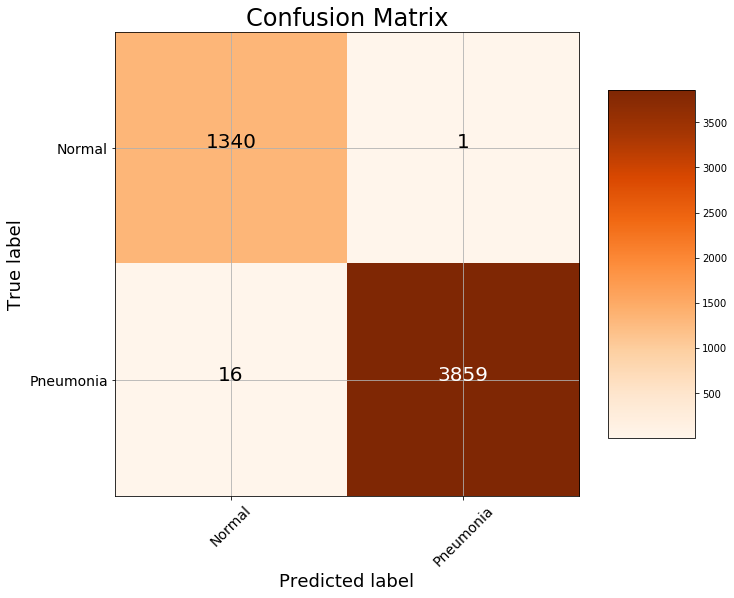

In [22]:
y_test=np.zeros(len(outPRED))
y_pred=np.zeros(len(outPRED))
y_pred[(outPRED[:,0].to(torch.device("cpu")).numpy().squeeze()>0.5)]=1
y_test[(outGT[:,0].to(torch.device("cpu")).numpy().squeeze()!=0)]=1
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Normal', 'Pneumonia'],
                      title = 'Confusion Matrix')

#### ROC curve for normal

0.9999703639556421


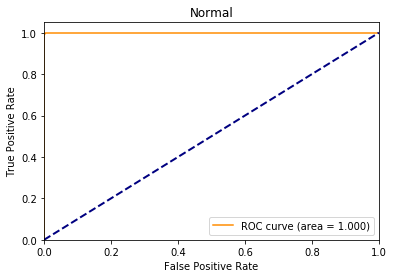

In [27]:
fpr, tpr, thresholds =roc_curve(outGT[:,0],outPRED[:,0],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normal')
plt.legend(loc="lower right")
print(sklearn.metrics.auc(fpr, tpr))
plt.show()

#### ROC curve for pneumonia

0.9999705563974887


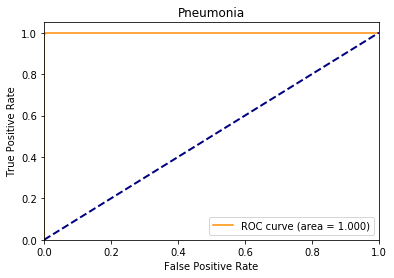

In [26]:
fpr, tpr, thresholds =roc_curve(outGT[:,1],outPRED[:,1],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pneumonia')
plt.legend(loc="lower right")
print(sklearn.metrics.auc(fpr, tpr))
plt.show()

#### ROC curve combined

Pneumonia 0.9999705563974887
Normal :  0.9999703639556421


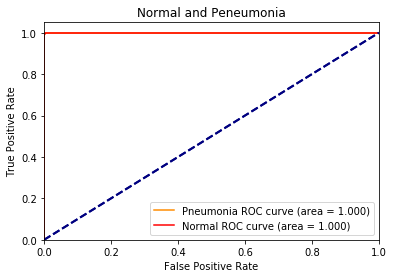

In [28]:
fpr, tpr, thresholds =roc_curve(outGT[:,1],outPRED[:,1],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='Pneumonia ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
print('Pneumonia',sklearn.metrics.auc(fpr, tpr))
fpr, tpr, thresholds =roc_curve(outGT[:,0],outPRED[:,0],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='Normal ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normal and Peneumonia')
plt.legend(loc="lower right")
print('Normal : ',sklearn.metrics.auc(fpr, tpr))
plt.show()

### Evaluation for testing

In [47]:
#-------------------- SETTINGS: DATA TRANSFORMS, TEN CROPS
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#-------------------- SETTINGS: DATASET BUILDERS
transformList = []
transformList.append(transforms.Resize(imgtransResize))
transformList.append(transforms.TenCrop(imgtransCrop))
transformList.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
transformList.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))
transformSequence=transforms.Compose(transformList)


datasetTest = DatasetGenerator(pathImageDirectory=pathDirData, pathDatasetFile=pathFileTest, transform=transformSequence)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=trBatchSize, num_workers=8, shuffle=False, pin_memory=True)

outGT = torch.FloatTensor().cuda()
outPRED = torch.FloatTensor().cuda()

model.eval()

DataParallel(
  (module): DenseNet121(
    (densenet121): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
       

In [48]:
for i, (input, target) in enumerate(dataLoaderTest):

    target = target.cuda()
    outGT = torch.cat((outGT, target), 0)

    bs, n_crops, c, h, w = input.size()

    varInput = torch.autograd.Variable(input.view(-1, c, h, w).cuda(), volatile=True)

    out = model(varInput)
    outMean = out.view(bs, n_crops, -1).mean(1)

    outPRED = torch.cat((outPRED, outMean.data), 0)

aurocIndividual = ChexnetTrainer.computeAUROC(outGT, outPRED, nnClassCount)
aurocMean = np.array(aurocIndividual).mean()

print ('AUROC mean ', aurocMean)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


AUROC mean  0.9956388341003726


#### Confusion matrix

Confusion matrix, without normalization
[[212  22]
 [  2 388]]


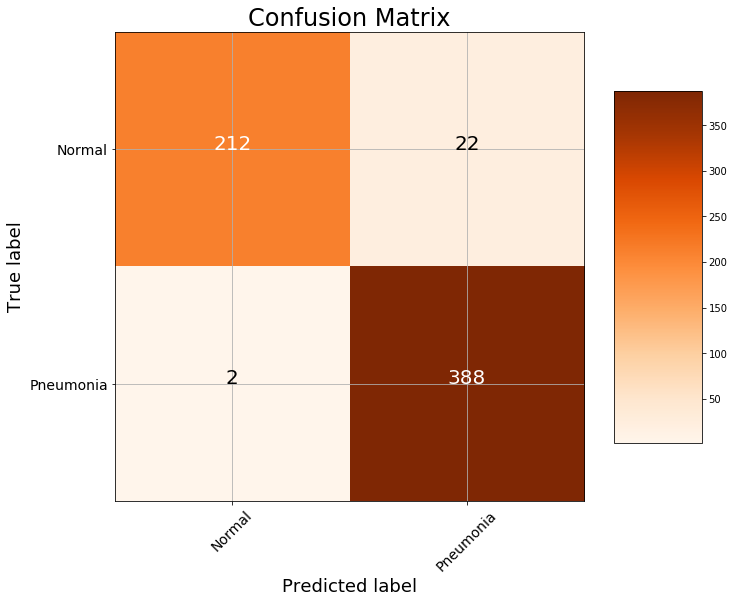

In [49]:
y_test=np.zeros(len(outPRED))
y_pred=np.zeros(len(outPRED))
y_pred[(outPRED[:,0].to(torch.device("cpu")).numpy().squeeze()>0.5)]=1
y_test[(outGT[:,0].to(torch.device("cpu")).numpy().squeeze()!=0)]=1
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Normal', 'Pneumonia'],
                      title = 'Confusion Matrix')

#### ROC curve for normal

0.9956169186938417


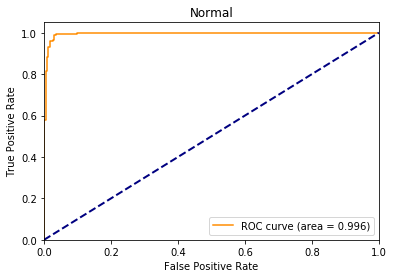

In [50]:
fpr, tpr, thresholds =roc_curve(outGT[:,0],outPRED[:,0],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normal')
plt.legend(loc="lower right")
print(sklearn.metrics.auc(fpr, tpr))
plt.show()

#### ROC curve for pneumonia

0.9956607495069034


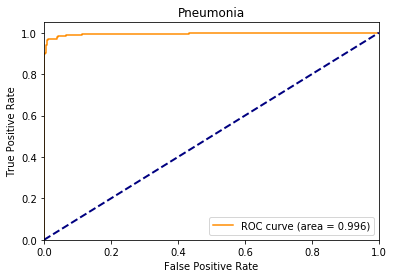

In [51]:
fpr, tpr, thresholds =roc_curve(outGT[:,1],outPRED[:,1],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pneumonia')
plt.legend(loc="lower right")
print(sklearn.metrics.auc(fpr, tpr))
plt.show()

#### ROC curve combined

Pneumonia 0.9956607495069034
Normal :  0.9956169186938417


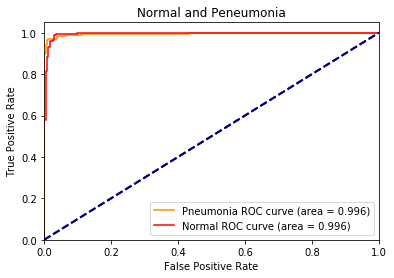

In [52]:
fpr, tpr, thresholds =roc_curve(outGT[:,1],outPRED[:,1],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='Pneumonia ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
print('Pneumonia',sklearn.metrics.auc(fpr, tpr))
fpr, tpr, thresholds =roc_curve(outGT[:,0],outPRED[:,0],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='Normal ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normal and Peneumonia')
plt.legend(loc="lower right")
print('Normal : ',sklearn.metrics.auc(fpr, tpr))
plt.show()

###  Evaluation for validation

In [35]:
#-------------------- SETTINGS: DATA TRANSFORMS, TEN CROPS
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#-------------------- SETTINGS: DATASET BUILDERS
transformList = []
transformList.append(transforms.Resize(imgtransResize))
transformList.append(transforms.TenCrop(imgtransCrop))
transformList.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
transformList.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))
transformSequence=transforms.Compose(transformList)

datasetTest = DatasetGenerator(pathImageDirectory=pathDirData, pathDatasetFile=pathFileVal, transform=transformSequence)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=trBatchSize, num_workers=8, shuffle=False, pin_memory=True)

outGT = torch.FloatTensor().cuda()
outPRED = torch.FloatTensor().cuda()

model.eval()

DataParallel(
  (module): DenseNet121(
    (densenet121): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
       

In [36]:
for i, (input, target) in enumerate(dataLoaderTest):

    target = target.cuda()
    outGT = torch.cat((outGT, target), 0)

    bs, n_crops, c, h, w = input.size()

    varInput = torch.autograd.Variable(input.view(-1, c, h, w).cuda(), volatile=True)

    out = model(varInput)
    outMean = out.view(bs, n_crops, -1).mean(1)

    outPRED = torch.cat((outPRED, outMean.data), 0)

aurocIndividual = ChexnetTrainer.computeAUROC(outGT, outPRED, nnClassCount)
aurocMean = np.array(aurocIndividual).mean()

print ('AUROC mean ', aurocMean)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


AUROC mean  1.0


#### Confusion matrix

Confusion matrix, without normalization
[[5 3]
 [0 8]]


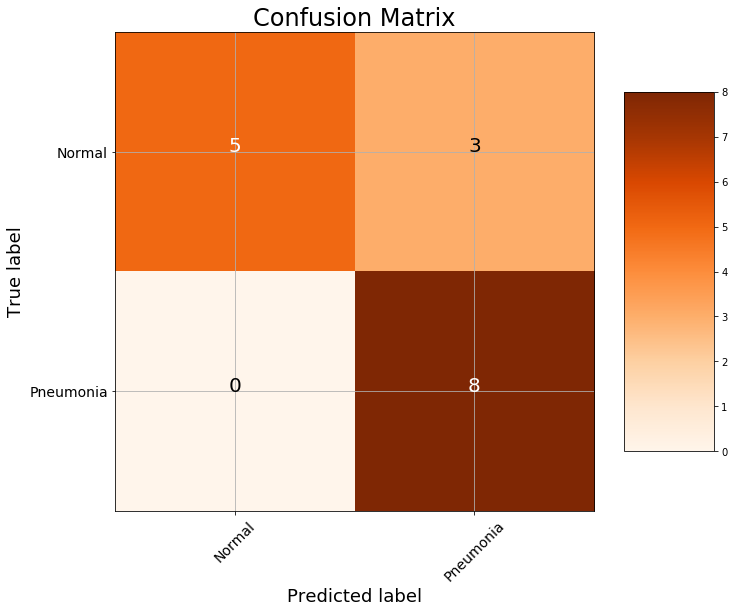

In [37]:
y_test=np.zeros(len(outPRED))
y_pred=np.zeros(len(outPRED))
y_pred[(outPRED[:,0].to(torch.device("cpu")).numpy().squeeze()>0.5)]=1
y_test[(outGT[:,0].to(torch.device("cpu")).numpy().squeeze()!=0)]=1
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Normal', 'Pneumonia'],
                      title = 'Confusion Matrix')

#### ROC curve for normal

1.0


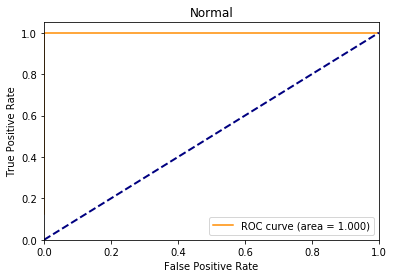

In [38]:
fpr, tpr, thresholds =roc_curve(outGT[:,0],outPRED[:,0],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normal')
plt.legend(loc="lower right")
print(sklearn.metrics.auc(fpr, tpr))
plt.show()

#### ROC curve for pneumonia

1.0


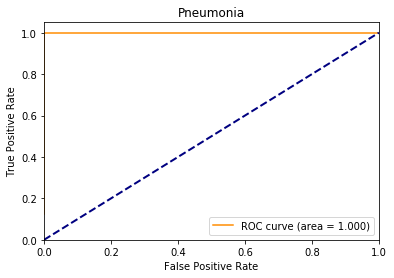

In [39]:
fpr, tpr, thresholds =roc_curve(outGT[:,1],outPRED[:,1],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pneumonia')
plt.legend(loc="lower right")
print(sklearn.metrics.auc(fpr, tpr))
plt.show()

#### ROC curve combined

Pneumonia 1.0
Normal :  1.0


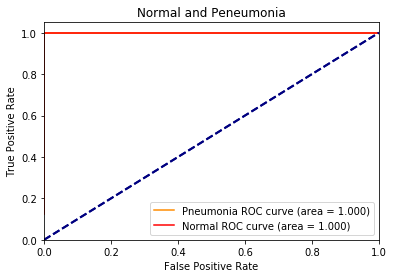

In [44]:
fpr, tpr, thresholds =roc_curve(outGT[:,1],outPRED[:,1],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',label='Pneumonia ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
print('Pneumonia',sklearn.metrics.auc(fpr, tpr))
fpr, tpr, thresholds =roc_curve(outGT[:,0],outPRED[:,0],pos_label=1)
roc_auc=sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',label='Normal ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Normal and Peneumonia')
plt.legend(loc="lower right")
print('Normal : ',sklearn.metrics.auc(fpr, tpr))
plt.show()